In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
import shutil
from datetime import datetime, timedelta
import os

warnings.filterwarnings('ignore')
tf.keras.utils.set_random_seed(4012)

C:\Users\user\AppData\Local\Temp\ipykernel_25760\618206802.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# 4, 5: MLP and RNN

In [2]:
df = pd.read_csv("data/bitcoin_daily_price.csv")
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'].between('2017-12-25', '2023-12-31')]
df.set_index('date', inplace=True)
df.describe()

,open,high,low,close,avg-block-size,blocks-size,cost-per-transaction,difficulty,hash-rate,market-cap,...,miners-revenue,n-transactions-excluding-popular,n-transactions-per-block,n-transactions-total,n-transactions,output-volume,total-bitcoins,trade-volume,transaction-fees-usd,transaction-fees
count,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2191.000000,2.191000e+03,2.191000e+03,2.191000e+03,...,2.191000e+03,2191.000000,2191.000000,2.191000e+03,2191.000000,2.191000e+03,2.191000e+03,2.191000e+03,2.191000e+03,2191.000000
mean,21747.222879,22243.218860,21208.222506,21758.150358,1.211223,324410.916008,84.024013,2.219291e+13,1.613669e+08,4.083439e+11,...,2.409920e+07,294770.111365,2058.317128,5.934332e+08,300343.041990,1.841883e+06,1.842829e+07,3.255299e+08,1.249401e+06,55.714535
std,16008.262626,16405.804320,15559.059013,16009.616698,0.302230,109946.110586,52.989861,1.621286e+13,1.199441e+08,3.061943e+11,...,1.427580e+07,88101.305368,586.702191,1.848251e+08,87776.543383,1.614969e+06,7.891729e+05,3.455227e+08,2.322768e+06,81.111052
min,3236.274658,3275.377930,3191.303467,3236.761719,0.431452,150110.786114,17.999771,1.922581e+12,1.372762e+07,5.534520e+10,...,4.666604e+06,123013.000000,834.129630,2.878462e+08,124640.000000,4.219402e+05,1.677550e+07,1.722276e+07,4.154115e+04,5.341647
25%,8322.410156,8522.882812,8143.933594,8321.381348,1.018420,228055.785389,48.512994,7.934713e+12,6.206519e+07,1.463344e+11,...,1.355411e+07,244334.500000,1699.670912,4.307076e+08,250087.000000,8.788179e+05,1.779427e+07,1.176241e+08,2.388563e+05,16.913454
50%,16975.238281,17197.498047,16788.783203,17034.292969,1.199630,318902.037985,66.425441,1.841516e+13,1.299339e+08,3.250901e+11,...,1.959227e+07,281607.000000,2001.926174,6.012346e+08,286638.000000,1.279472e+06,1.858644e+07,2.118677e+08,4.804184e+05,26.718137
75%,32134.140625,33309.777344,30855.880859,32156.772461,1.323910,414399.230146,105.816160,2.957017e+13,2.145460e+08,6.016498e+11,...,3.130730e+07,323023.000000,2284.024982,7.456263e+08,330694.500000,2.224911e+06,1.908265e+07,3.824520e+08,9.700209e+05,66.845094
max,67549.734375,68789.625000,66382.062500,67566.828125,2.524785,537822.520338,300.310549,7.200615e+13,6.120851e+08,1.275587e+12,...,8.017224e+07,731152.000000,4688.147436,9.451676e+08,731351.000000,2.452867e+07,1.958568e+07,3.408073e+09,2.375189e+07,778.261095


## Preprocessing

In [3]:
df['Volume'] = np.log(df['Volume']+1)
df[['Open_diff', 'High_diff', 'Low_diff', 'Close_diff', 'Adj Close_diff']]= df[['Open', 'High', 'Low', 'Close', 'Adj Close']].diff()
df = df.dropna()
df = df[['Open_diff', 'High_diff', 'Low_diff', 'Close_diff', 'Adj Close_diff', 'Open', 'High', 'Low', 'Close', 'Adj Close']]

In [4]:
# Convert the time series data into sequences with the specified number of time steps
def create_sequences(X, y, time_steps):
    n = len(y) - time_steps - 1
    if len(X.shape) == 1:
        X_transform = np.zeros((n, time_steps))
    else: X_transform = np.zeros((n, time_steps, X.shape[1]))
    y_transform = np.zeros((n, 1))
    for i in range(n):
        X_transform[i] = X[i:i+time_steps]
        y_transform[i] = y[i+time_steps+1]
    return X_transform, y_transform

In [5]:
def preprocessing(method, df, time_steps, train_range=['2018-01-01', '2022-12-31'], test_range=['2023-01-01', '2023-12-31']):
    df_copy = df.copy()
    
    # train-test mask
    df_copy_index = df_copy.index[np.logical_and(df_copy.index >= (df_copy.index[0] + timedelta(days=time_steps)).strftime('%Y-%m-%d'),
                                    df_copy.index <= (df_copy.index[-1] - timedelta(days=1)).strftime('%Y-%m-%d'))]
    train_start, train_end = (datetime.strptime(train_range[0], '%Y-%m-%d').date() - timedelta(days=time_steps)).strftime('%Y-%m-%d'), \
                        (datetime.strptime(train_range[1], '%Y-%m-%d').date() - timedelta(days=time_steps)).strftime('%Y-%m-%d')
    train_start, train_end = train_range
    train_mask = ((df_copy_index >= train_start) & (df_copy_index <= train_end))
    test_start, test_end = (datetime.strptime(test_range[0], '%Y-%m-%d').date() - timedelta(days=1)).strftime('%Y-%m-%d'), test_range[1]
    test_mask = ((df_copy_index >= test_start) & (df_copy_index <= test_end))
    
    if method == 'MinMax':
        scaler = MinMaxScaler()
    elif method == 'RobustScaling':
        scaler = RobustScaler()
    elif method == 'NoScaling':
        scaler = None
    elif method == 'StandardScaling':
        scaler = StandardScaler()
        
    if method != 'NoScaling':
        array = scaler.fit_transform(df_copy)
        scaler.fit_transform(np.expand_dims(df_copy.iloc[:,0],1))
    else: array = df.values
    
    # the first column is the output value
    X, y = create_sequences(array, array[:,0], time_steps)
    # train-test split
    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    
    return scaler, (X_train, y_train, X_test, y_test)

In [6]:
no_scalar, (X_train_no, y_train_no, X_test_no, y_test_no) = preprocessing("NoScaling", df, time_steps=5)
mm_scalar, (X_train_mm, y_train_mm, X_test_mm, y_test_mm) = preprocessing("MinMax", df, time_steps=5)
rb_scalar, (X_train_rb, y_train_rb, X_test_rb, y_test_rb) = preprocessing('RobustScaling', df, time_steps=5)
sd_scalar, (X_train_sd, y_train_sd, X_test_sd, y_test_sd) = preprocessing('StandardScaling', df, time_steps=5)

## Build model

### MLP structure

In [7]:
def MLP_tuning(hp):
    max_layers = 4
    model = Sequential()

    activation = hp.Choice('activation', values=['sigmoid', 'relu'])

    num_rnn_layers = hp.Int('num_dnn_layers', min_value=1, max_value=max_layers, default=1)
    units_dnn = []
    dropout_dnn = []

    for i in range(num_rnn_layers):
        units_dnn.append(hp.Choice(f'units_dnn{i+1}', values=[16, 32, 64, 128]))
        dropout_dnn.append(hp.Float(f'dropout{i+1}', min_value=0.0, max_value=0.5, step=0.1))
            
            
    print(num_rnn_layers,units_dnn,dropout_dnn)
    # print(f"trial\nunits: {units_rnn}\ndropout: {dropout_rnn}")
    for i in range(num_rnn_layers):
        model.add(Dense(units=units_dnn[i],
                            activation=activation,
                            # input_shape=array.shape[1:],
                            ))
        if dropout_dnn[i] > 0:
            model.add(Dropout(dropout_dnn[i]))
    # Add more layers as needed
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

### RNN structure

In [8]:
def RNN_tuning(hp):
    max_layers = 4
    model = Sequential()
    activation = hp.Choice('activation', values=['sigmoid', 'relu'])

    num_rnn_layers = hp.Int('num_rnn_layers', min_value=1, max_value=max_layers, default=1)
    units_rnn = []
    dropout_rnn = []
    return_sequences = []

    for i in range(num_rnn_layers):
        units_rnn.append(hp.Choice(f'units_rnn{i+1}', values=[16, 32, 64, 128]))
        dropout_rnn.append(hp.Float(f'dropout{i+1}', min_value=0.0, max_value=0.5, step=0.1))
        if i == num_rnn_layers - 1:
            return_sequences.append(False)  # Last layer, return_sequences = False
        else:
            return_sequences.append(True)  # Not the last layer, return_sequences = True
            
            
    print(num_rnn_layers,units_rnn,dropout_rnn)
    # print(f"trial\nunits: {units_rnn}\ndropout: {dropout_rnn}")
    for i in range(num_rnn_layers):
        model.add(SimpleRNN(units=units_rnn[i],
                            activation=activation,
                            # input_shape=array.shape[1:],
                            return_sequences=return_sequences[i]))
        if dropout_rnn[i] > 0:
            model.add(Dropout(dropout_rnn[i]))
    # Add more layers as needed
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


### Loop model with scaling methods

In [9]:
def train_loop(train_data, hp_model):
    models= []
    histories = []
    dir_path = 'model_files'
    for array, y in train_data:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        # Define the hyperparameter search space
        tuner = RandomSearch(
            hp_model,
            objective='val_loss',
            max_trials=20,
            executions_per_trial=1,
            directory=dir_path,
            project_name='my_project'
        )

        early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=4, mode='min', restore_best_weights=True, min_delta=1e-5)
        tuner.search(array, y, validation_split=0.2, batch_size=32, epochs=1000, shuffle=True,  callbacks=[early_stopping])
        tuner.results_summary()

        # Get the best model
        model = tuner.get_best_models(num_models=1)[0]
        models.append(model)
        history = model.fit(array, y, validation_split=0.2, batch_size=32, epochs=1000, shuffle=True,  callbacks=[early_stopping])
        histories.append(history)
        
    return models, histories

In [10]:
# check the structure for each model
def model_structure(model, name_of_model):
    print(name_of_model)
    for layer in model.layers:
        # dropout layer
        if isinstance(layer, Dropout):
            print(f"Dropout: {layer.rate}")
            continue
        # normal layer
        print(layer.name, layer.activation.__name__)
        print(layer.name, layer.get_weights()[0].shape[1])
    print()

## 4. MLP

In [11]:
train_data_MLP = zip([X_train_no.reshape(-1, 40), X_train_mm.reshape(-1, 40), X_train_rb.reshape(-1, 40), X_train_sd.reshape(-1, 40)],
                 [y_train_no, y_train_mm, y_train_rb, y_train_sd])
models_MLP, histories_MLP = train_loop(train_data_MLP, MLP_tuning)

Trial 20 Complete [00h 00m 04s]
val_loss: 1.1649426221847534

Best val_loss So Far: 1.114670991897583
Total elapsed time: 00h 01m 40s
Results summary
Results in model_files\my_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 00 summary
Hyperparameters:
activation: relu
num_dnn_layers: 2
units_dnn1: 32
dropout1: 0.30000000000000004
units_dnn2: 16
dropout2: 0.0
Score: 1.114670991897583

Trial 08 summary
Hyperparameters:
activation: relu
num_dnn_layers: 2
units_dnn1: 32
dropout1: 0.0
units_dnn2: 16
dropout2: 0.4
units_dnn3: 128
dropout3: 0.30000000000000004
Score: 1.1147414445877075

Trial 11 summary
Hyperparameters:
activation: sigmoid
num_dnn_layers: 1
units_dnn1: 16
dropout1: 0.4
units_dnn2: 16
dropout2: 0.2
units_dnn3: 32
dropout3: 0.2
Score: 1.1150305271148682

Trial 09 summary
Hyperparameters:
activation: sigmoid
num_dnn_layers: 3
units_dnn1: 32
dropout1: 0.0
units_dnn2: 16
dropout2: 0.2
units_dnn3: 32
dropout3: 0.4
Score: 1.1156343221664429

Trial 0

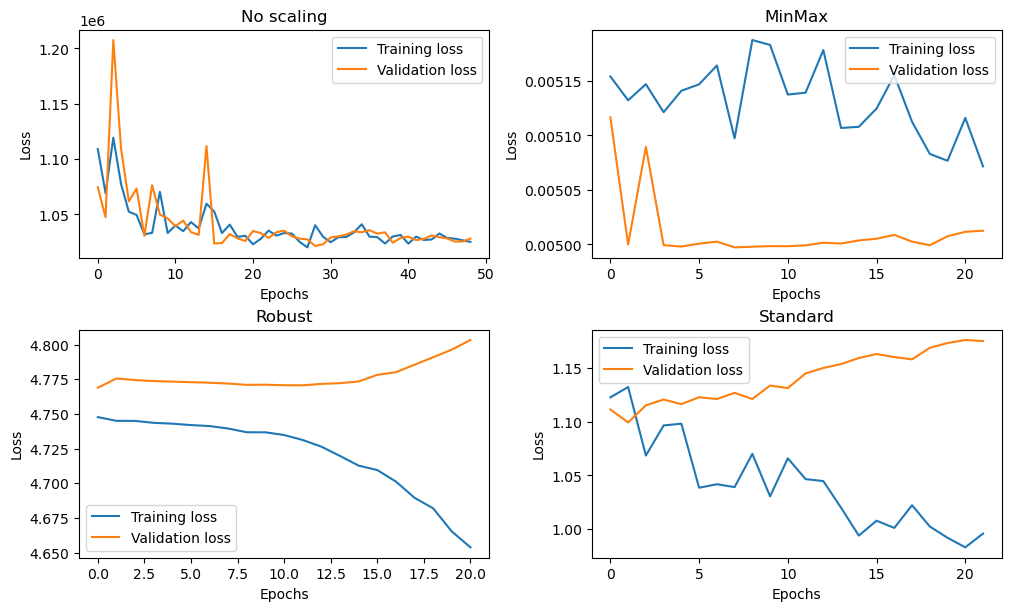

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
fax = ax.ravel()
scaling_labels = ["No scaling", "MinMax", "Robust", "Standard"]

for i, history, label in zip(range(4), histories_MLP, scaling_labels):
    fax[i].plot(history.history['loss'], label="Training loss")
    fax[i].plot(history.history['val_loss'], label="Validation loss")
    fax[i].set_xlabel('Epochs')
    fax[i].set_ylabel('Loss')
    fax[i].legend()
    fax[i].set_title(label)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
test no mse: 433616.0368174937
test mm mse: 443705.4277539178
test rb mse: 426920.1233319749
test sd mse: 440371.9891022752


Text(0, 0.5, 'Difference in Price')

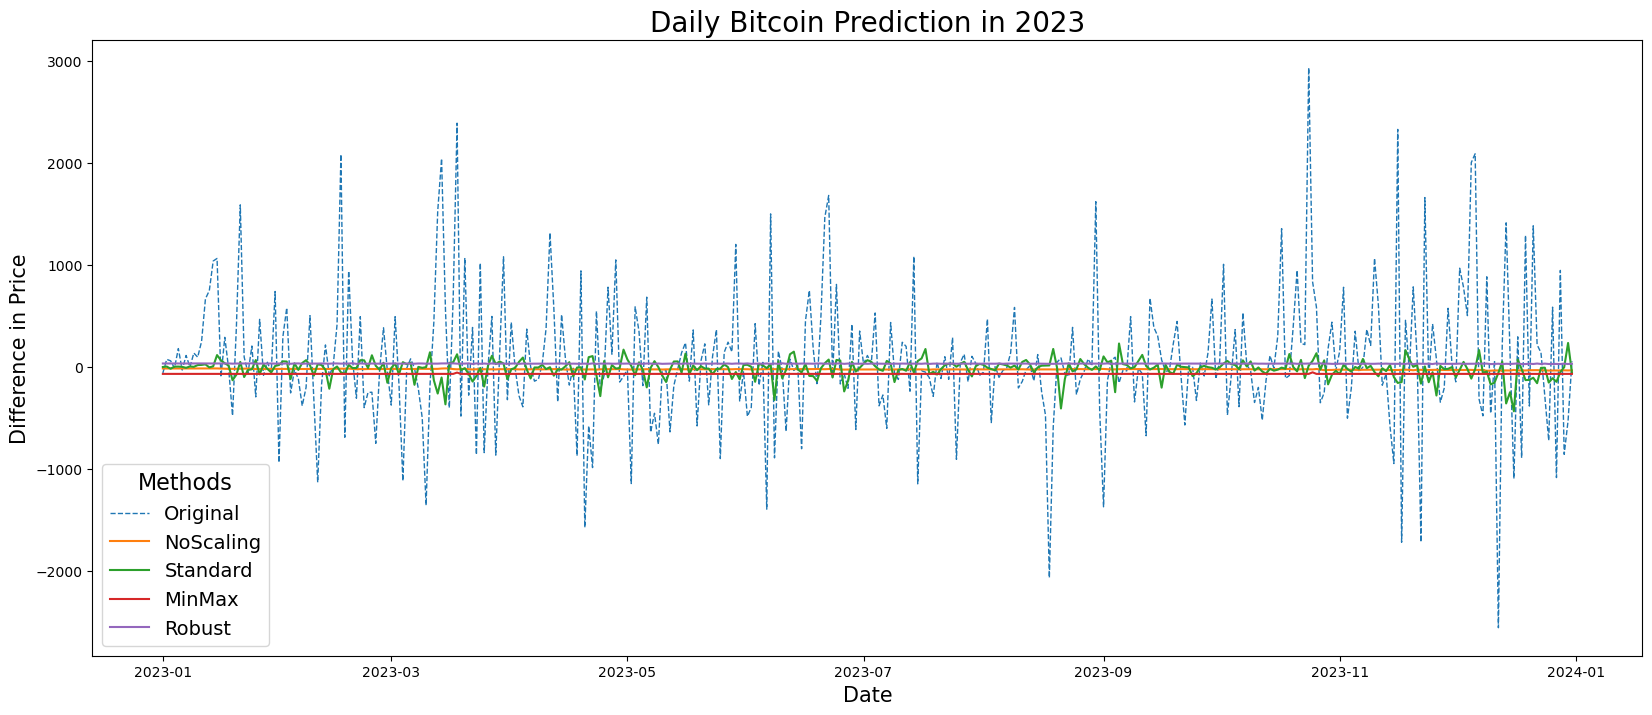

In [13]:
y_pred_no = models_MLP[0].predict(X_test_no.reshape(-1, 40))
y_pred_mm = models_MLP[1].predict(X_test_mm.reshape(-1, 40))
y_pred_mm = mm_scalar.inverse_transform(y_pred_mm)
y_pred_rb = models_MLP[2].predict(X_test_rb.reshape(-1, 40))
y_pred_rb = rb_scalar.inverse_transform(y_pred_rb)
y_pred_sd = models_MLP[3].predict(X_test_sd.reshape(-1, 40))
y_pred_sd = sd_scalar.inverse_transform(y_pred_sd)

print(f"test no mse: {np.mean((y_pred_no-y_test_no)**2)}")
print(f"test mm mse: {np.mean((y_pred_mm-y_test_no)**2)}")
print(f"test rb mse: {np.mean((y_pred_rb-y_test_no)**2)}")
print(f"test sd mse: {np.mean((y_pred_sd-y_test_no)**2)}")

date = pd.date_range("2023-01-01", "2023-12-31")

fig = plt.figure(figsize=(20,8))
plt.plot(date, y_test_no, label='Original', ls="--", lw=1)
plt.plot(date, y_pred_no, label='NoScaling')
plt.plot(date, y_pred_sd, label='Standard')
plt.plot(date, y_pred_mm, label='MinMax')
plt.plot(date, y_pred_rb, label='Robust')

plt.legend(title='Methods', fontsize=14, title_fontsize=16)
plt.title('Daily Bitcoin Prediction in 2023', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Difference in Price', fontsize=15)

In [14]:
for model, name in zip(models_MLP, ["no", "mm", "rb", "sc"]):
    model_structure(model, name)

no
dense relu
dense 64
Dropout: 0.30000000000000004
dense_1 relu
dense_1 16
dense_2 relu
dense_2 16
dense_3 relu
dense_3 16
dense_4 linear
dense_4 1

mm
dense relu
dense 32
Dropout: 0.4
dense_1 relu
dense_1 64
dense_2 relu
dense_2 64
dense_3 linear
dense_3 1

rb
dense sigmoid
dense 128
Dropout: 0.2
dense_1 sigmoid
dense_1 16
dense_2 sigmoid
dense_2 16
dense_3 sigmoid
dense_3 16
dense_4 linear
dense_4 1

sc
dense relu
dense 32
Dropout: 0.30000000000000004
dense_1 relu
dense_1 16
dense_2 linear
dense_2 1



## 5. RNN

In [15]:
train_data_RNN = zip([X_train_no, X_train_mm, X_train_rb, X_train_sd],
                 [y_train_no, y_train_mm, y_train_rb, y_train_sd])

models_RNN, histories_RNN = train_loop(train_data_RNN, RNN_tuning)

Trial 20 Complete [00h 00m 18s]
val_loss: 1.1171540021896362

Best val_loss So Far: 1.0947829484939575
Total elapsed time: 00h 04m 46s
Results summary
Results in model_files\my_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
activation: relu
num_rnn_layers: 3
units_rnn1: 16
dropout1: 0.30000000000000004
units_rnn2: 32
dropout2: 0.0
units_rnn3: 64
dropout3: 0.2
Score: 1.0947829484939575

Trial 16 summary
Hyperparameters:
activation: sigmoid
num_rnn_layers: 3
units_rnn1: 16
dropout1: 0.30000000000000004
units_rnn2: 16
dropout2: 0.4
units_rnn3: 128
dropout3: 0.30000000000000004
units_rnn4: 128
dropout4: 0.30000000000000004
Score: 1.1005109548568726

Trial 07 summary
Hyperparameters:
activation: relu
num_rnn_layers: 4
units_rnn1: 16
dropout1: 0.30000000000000004
units_rnn2: 16
dropout2: 0.4
units_rnn3: 32
dropout3: 0.4
units_rnn4: 16
dropout4: 0.0
Score: 1.104512333869934

Trial 14 summary
Hyperparameters:
activation: sigmoid
nu

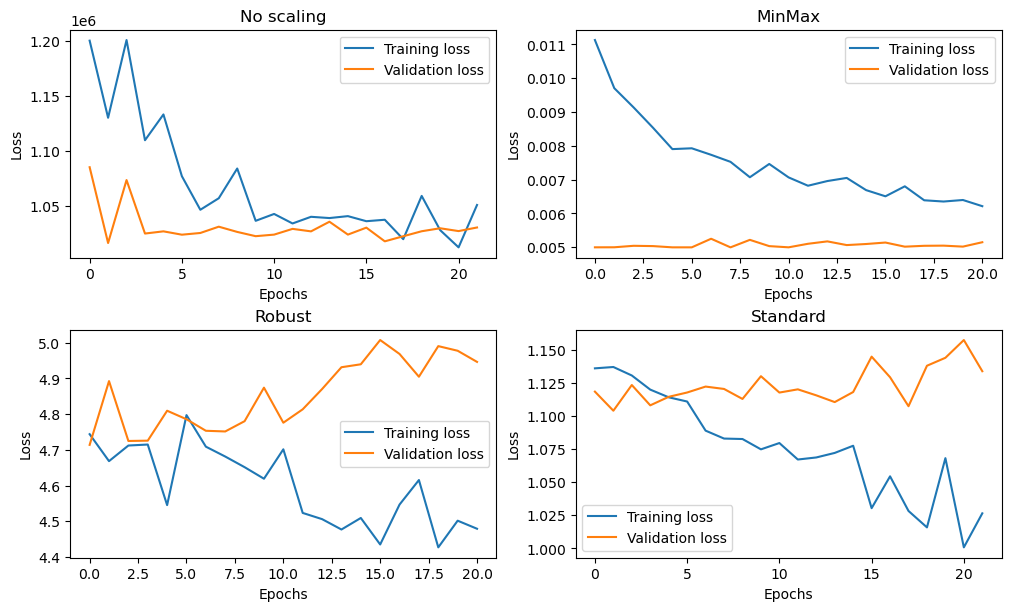

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), layout='constrained')
fax = ax.ravel()
scaling_labels = ["No scaling", "MinMax", "Robust", "Standard"]

for i, history, label in zip(range(4), histories_RNN, scaling_labels):
    fax[i].plot(history.history['loss'], label="Training loss")
    fax[i].plot(history.history['val_loss'], label="Validation loss")
    fax[i].set_xlabel('Epochs')
    fax[i].set_ylabel('Loss')
    fax[i].legend()
    fax[i].set_title(label)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
test no mse: 448043.0894205893
test mm mse: 453921.57410132384
test rb mse: 427470.9141706561
test sd mse: 427954.1847994257


Text(0, 0.5, 'Difference in Price')

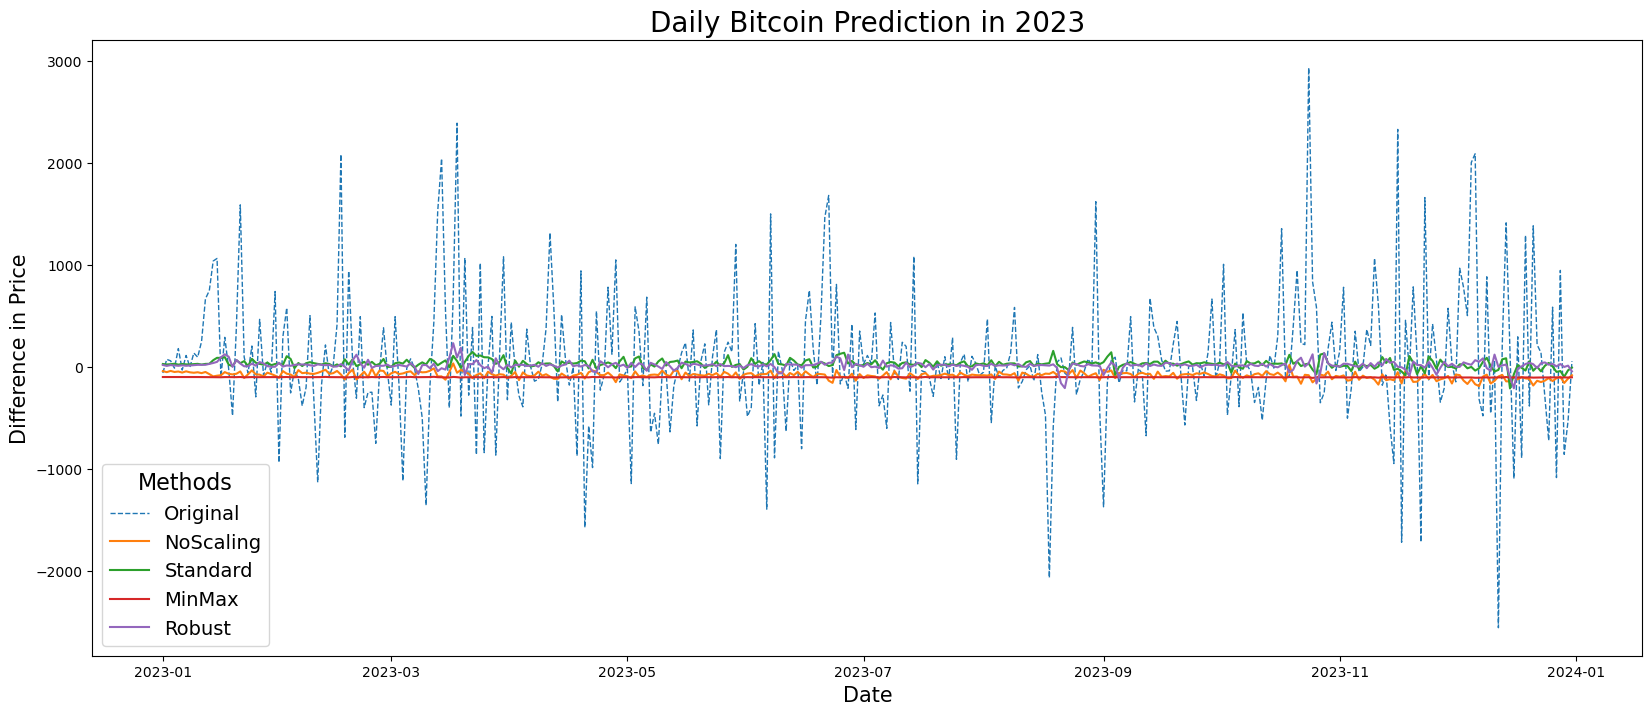

In [17]:
y_pred_no = models_RNN[0].predict(X_test_no)
y_pred_mm = models_RNN[1].predict(X_test_mm)
y_pred_mm = mm_scalar.inverse_transform(y_pred_mm)
y_pred_rb = models_RNN[2].predict(X_test_rb)
y_pred_rb = rb_scalar.inverse_transform(y_pred_rb)
y_pred_sd = models_RNN[3].predict(X_test_sd)
y_pred_sd = sd_scalar.inverse_transform(y_pred_sd)

print(f"test no mse: {np.mean((y_pred_no-y_test_no)**2)}")
print(f"test mm mse: {np.mean((y_pred_mm-y_test_no)**2)}")
print(f"test rb mse: {np.mean((y_pred_rb-y_test_no)**2)}")
print(f"test sd mse: {np.mean((y_pred_sd-y_test_no)**2)}")

date = pd.date_range("2023-01-01", "2023-12-31")

fig = plt.figure(figsize=(20,8))
plt.plot(date, y_test_no, label='Original', ls="--", lw=1)
plt.plot(date, y_pred_no, label='NoScaling')
plt.plot(date, y_pred_sd, label='Standard')
plt.plot(date, y_pred_mm, label='MinMax')
plt.plot(date, y_pred_rb, label='Robust')

plt.legend(title='Methods', fontsize=14, title_fontsize=16)
plt.title('Daily Bitcoin Prediction in 2023', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Difference in Price', fontsize=15)

In [18]:
for model, name in zip(models_RNN, ["no", "mm", "rb", "sc"]):
    model_structure(model, name)

no
simple_rnn relu
simple_rnn 16
Dropout: 0.4
simple_rnn_1 relu
simple_rnn_1 64
Dropout: 0.2
dense linear
dense 1

mm
simple_rnn sigmoid
simple_rnn 64
Dropout: 0.30000000000000004
simple_rnn_1 sigmoid
simple_rnn_1 64
Dropout: 0.30000000000000004
dense linear
dense 1

rb
simple_rnn relu
simple_rnn 16
Dropout: 0.4
simple_rnn_1 relu
simple_rnn_1 128
Dropout: 0.1
simple_rnn_2 relu
simple_rnn_2 16
simple_rnn_3 relu
simple_rnn_3 32
Dropout: 0.1
dense linear
dense 1

sc
simple_rnn relu
simple_rnn 16
Dropout: 0.30000000000000004
simple_rnn_1 relu
simple_rnn_1 32
simple_rnn_2 relu
simple_rnn_2 64
Dropout: 0.2
dense linear
dense 1

